---

LangGraph is created to define cyclical graphs. Graphs consist of the following elements:

- Nodes represent actual actions and can be either LLMs, agents or functions. Also, a special END node marks the end of execution.
- Edges connect nodes and determine the execution flow of your graph. There are basic edges that simply link one node to another and conditional edges that incorporate if-statements and additional logic.

In [10]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)


graph.add_node("branch_a", modify_state )
graph.add_node("branch_b", modify_state)

graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

workflow = graph.compile()

In [ ]:
from IPython.display import Image
display(Image(workflow.get_graph().draw_mermaid_png()))


In [11]:
print(workflow.get_graph().draw_mermaid())


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	branch_a(branch_a)
	branch_b(branch_b)
	__end__([<p>__end__</p>]):::last
	__start__ --> branch_a;
	branch_a --> branch_b;
	branch_b --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [12]:
workflow.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state_for_branch_a(input: InputState):
    print(f"Current value at brach a: {input}")
    return input

def modify_state_for_branch_b(input: InputState):
    print(f"Current value at branch b: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state_for_branch_a )
graph.add_node("branch_b", modify_state_for_branch_b)

graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

workflow = graph.compile()

In [18]:
workflow.invoke({"string_value": "a", "numeric_value":9})

Current value at brach a: {'string_value': 'a', 'numeric_value': 9}
Current value at branch b: {'string_value': 'a', 'numeric_value': 9}


{'string_value': 'a', 'numeric_value': 9}

In [23]:
def modify_state(input: InputState):
    input["string_value"] += "s"
    input["numeric_value"] += 1
    return input

test = {
    "string_value": 'Van',
    "numeric_value":1000
}


modify_state(test)

{'string_value': 'Vans', 'numeric_value': 1001}

In [25]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input

graph = StateGraph(InputState)



graph.add_node("branch_a", modify_state )
graph.add_node("branch_b", modify_state)

graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

workflow = graph.compile()

In [26]:
workflow.invoke({"string_value": "a", "numeric_value":10})

{'string_value': 'aaa', 'numeric_value': 12}

In [28]:
print(workflow.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	branch_a(branch_a)
	branch_b(branch_b)
	__end__([<p>__end__</p>]):::last
	__start__ --> branch_a;
	branch_a --> branch_b;
	branch_b --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



---

In [29]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    number1: int 
    operation: str 
    number2: int
    finalNumber: int


In [33]:
def adder(state:AgentState) -> AgentState:
    """This node adds the 2 numbers"""
    state["finalNumber"] = state["number1"] + state["number2"]

    return state

def subtractor(state:AgentState) -> AgentState:
    """This node subtracts the 2 numbers"""
    state["finalNumber"] = state["number1"] - state["number2"]
    return state


def decide_next_node(state:AgentState) -> AgentState:
    """This node will select the next node of the graph"""

    if state['operation']=='+':
        return 'addition_operation'
    
    elif state['operation']=='-':
        return 'subtraction_operation'

graph = StateGraph(AgentState)


graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state: state )


graph.add_edge(START, "router") 

graph.add_conditional_edges("router", decide_next_node,
                            
                            {
                                "addition_operation":"add_node",
                                "subtraction_operation":"subtract_node"
                            }
)
                            
          
graph.add_edge("add_node", END) 

graph.add_edge("subtract_node", END)                   


app = graph.compile()

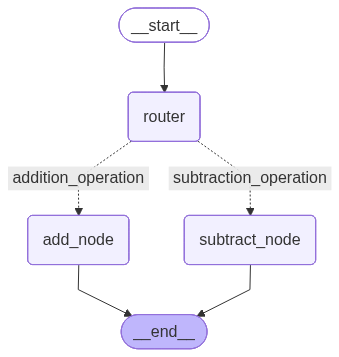

In [35]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
initial_state_1 = AgentState(number1 = 10, operation="-", number2 = 5)
print(app.invoke(initial_state_1))

{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5}


In [38]:
# This way still works!

result = app.invoke({"number1": 10, "operation": "+", "number2": 5})
print(result)

{'number1': 10, 'operation': '+', 'number2': 5, 'finalNumber': 15}


HW: 